## Generating the Data

In [1]:
import pandas as pd
import random
from faker import Faker
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Initialize Faker instance
fake = Faker()

# Generate Customer Demographics Data
def generate_customer_demographics(num_customers=1000):
    customer_data = []
    for _ in range(num_customers):
        customer = {
            'customer_id': fake.uuid4(),
            'name': fake.name(),
            'age': random.randint(18, 70),
            'gender': random.choice(['Male', 'Female']),
            'marital_status': random.choice(['Single', 'Married', 'Divorced']),
            'education': random.choice(['High School','Diploma', 'Bachelor', 'Master', 'PhD']),
            'occupation': fake.job(),
            'salary': random.randint(500000, 3000000),  # Yearly salary
        }
        customer_data.append(customer)
    return pd.DataFrame(customer_data)

# Generate Customer Financial Behavior Data
def generate_financial_behavior(customer_ids, num_records=2000):
    financial_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        loan_amount = random.randint(500000, 10000000) if product_type != 'Credit Card' else random.randint(5000, 100000)
        credit_limit = random.randint(50000, 150000) if product_type == 'Credit Card' else None
        utilization = random.uniform(0.1, 1.0) if product_type == 'Credit Card' else None
        max_dpd = random.choice([0, 15, 30, 60, 90, 120])
        default_status = random.choice([True, False])

        financial_behavior = {
            'customer_id': random.choice(customer_ids),
            'product_type': product_type,
            'loan_amount': loan_amount,
            'credit_limit': credit_limit,
            'credit_utilization': utilization,
            'emi_paid': random.randint(1, 24),
            'tenure_months': random.randint(12, 60),
            'max_dpd': max_dpd,
            'default_status': default_status
        }
        financial_data.append(financial_behavior)
    return pd.DataFrame(financial_data)

# Generate Customer Enquiries Data (Last 3 months)
def generate_customer_enquiries(customer_ids, num_records=500):
    enquiries_data = []
    for _ in range(num_records):
        product_type = random.choice(['Personal Loan', 'Home Loan', 'Credit Card'])
        enquiry_amount = random.randint(100000, 1500000) if product_type != 'Credit Card' else random.randint(5000, 100000)
        enquiry = {
            'customer_id': random.choice(customer_ids),
            'enquiry_date': fake.date_between(start_date='-90d', end_date='today'),
            'product_type': product_type,
            'enquiry_amount': enquiry_amount,
            'status': random.choice(['Approved', 'Rejected'])
        }
        enquiries_data.append(enquiry)
    return pd.DataFrame(enquiries_data)

# Generate Customer Transaction Data (Past 6 months)
def generate_customer_transactions(customer_ids, num_records=5000):
    transactions_data = []
    for _ in range(num_records):
        transaction_date = fake.date_between(start_date='-180d', end_date='today')
        transaction_amount = random.uniform(50, 10000)
        
        # Transaction description with salary-related and hobby keywords
        transaction_description = random.choice([
            'Salary', 'Flipkart Purchase', 'Grocery Store', 'Gym Membership',
            'Netflix Subscription', 'Restaurant', 'Fuel Station', 'Travel Booking', 
            'Swiggy Order', 'Zomato Order', 'Mobile Recharge', 'Electricity Bill',
            'Rent Payment', 'Car Insurance', 'IRCTC Booking', 'Bus Ticket', 'Spotify Subscription',
            'Ola Ride', 'Concert Ticket', 'Books Purchase', 'Amazon Shopping'
        ])

        # Salary detection
        salary_keywords = ['Salary', 'SALARY', 'SAL', 'SAL credited', 'Monthly Salary']
        is_salary = any(keyword in transaction_description.upper() for keyword in salary_keywords)

        # Hobbies detection based on transaction descriptions
        hobbies = None
        if "Flipkart" in transaction_description or "Amazon" in transaction_description:
            hobbies = 'Shopping'
        elif "Netflix" in transaction_description or "Spotify" in transaction_description:
            hobbies = 'Entertainment'
        elif "Gym" in transaction_description:
            hobbies = 'Fitness'
        elif "Travel" in transaction_description or "IRCTC" in transaction_description:
            hobbies = 'Travel'

        transaction = {
            'customer_id': random.choice(customer_ids),
            'transaction_date': transaction_date,
            'transaction_amount': transaction_amount,
            'transaction_description': transaction_description,
            'account_balance': random.uniform(500, 20000),
            'is_salary': is_salary,
            'hobby_detected': hobbies
        }
        transactions_data.append(transaction)

    return pd.DataFrame(transactions_data)

# Generate consistent data across all categories
customers = generate_customer_demographics(5000)
financial_behavior = generate_financial_behavior(customers['customer_id'], num_records=25000)
enquiries = generate_customer_enquiries(customers['customer_id'], num_records=12000)
transactions = generate_customer_transactions(customers['customer_id'], num_records=35000)



In [3]:
# Combine Data for Clustering
# Aggregating financial and transaction data by customer_id to create summary features
financial_summary = financial_behavior.groupby('customer_id').agg({
    'loan_amount': 'mean',
    'credit_limit': 'mean',
    'credit_utilization': 'mean',
    'emi_paid': 'sum',
    'tenure_months': 'mean',
    'max_dpd': 'max',
    'default_status': 'mean',
    'product_type':'unique'
}).reset_index()

transaction_summary = transactions.groupby('customer_id').agg({
    'transaction_amount': 'mean',
    'account_balance': 'mean',
    'is_salary': 'sum',
    'transaction_amount': lambda x: x[transactions['is_salary'] == 1].sum()
}).reset_index()

# Assuming 'enquiries' has columns like ['customer_id', 'product_type', 'enquiry_date', 'enquiry_amount']
enquiries_summary = enquiries.groupby('customer_id').agg({
    'enquiry_amount': 'mean',  # Average amount enquired
    'product_type': lambda x: x.nunique(),  # Number of unique products enquired
    'customer_id': 'count'  # Total number of enquiries
}).rename(columns={
    'customer_id': 'total_enquiries',
    'product_type': 'unique_products_enquired'
}).reset_index()

# Merging demographics, financial behavior, and transaction summary
merged_data = pd.merge(customers, financial_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, enquiries_summary, on='customer_id', how='left')
merged_data = pd.merge(merged_data, transaction_summary, on='customer_id', how='left')


In [4]:
merged_data.head()

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,tenure_months,max_dpd,default_status,product_type,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary
0,92eef4b2-dbde-41ef-aed9-6329ecf297c9,Allen Hall,58,Male,Divorced,High School,Chief Financial Officer,815625,2.124278e+05,96048.666667,...,30.500000,120.0,0.5,"[Credit Card, Home Loan]",846793.000000,1.0,1.0,9493.055654,8839.935234,2.0
1,a57ad013-7723-45d0-b150-c7273365d0a8,Bridget West,67,Female,Single,Master,Sub,1101901,3.037900e+05,91297.000000,...,47.500000,90.0,0.5,"[Home Loan, Credit Card]",481866.857143,2.0,7.0,6708.535002,11193.988647,1.0
2,495452b6-7838-4635-8f07-a5f420d0b04f,Julian Castro,37,Male,Divorced,Bachelor,Barista,1783301,3.686987e+06,116003.666667,...,31.400000,120.0,0.6,"[Personal Loan, Home Loan, Credit Card]",564709.250000,3.0,4.0,0.000000,7172.105887,0.0
3,4d67d4b2-9b72-4306-a9e6-e004be6e4cbc,Robert Larson,69,Female,Single,Bachelor,Forensic scientist,924686,3.499822e+06,83661.000000,...,33.833333,120.0,1.0,"[Credit Card, Home Loan, Personal Loan]",805806.000000,1.0,1.0,0.000000,12008.877460,0.0
4,3c2a74db-3311-4420-aafd-107db5074a49,Thomas Gonzalez,60,Female,Divorced,Diploma,Clinical biochemist,1537822,3.589813e+06,110603.000000,...,38.750000,90.0,1.0,"[Credit Card, Home Loan, Personal Loan]",248048.333333,3.0,3.0,0.000000,8794.744958,0.0


In [5]:
# Step 1: Explode the list in 'product_type' column
df_exploded = merged_data.explode('product_type')

# Step 2: One-hot encode the 'product_type' column
df_encoded = pd.get_dummies(df_exploded['product_type'])

merged_data = pd.concat([df_exploded, df_encoded], axis=1)

# Step 4: Group by the original index and aggregate to bring it back into one row per customer
df_final = merged_data.groupby(merged_data.index).sum()
df_final.columns

Index(['customer_id', 'name', 'age', 'gender', 'marital_status', 'education',
       'occupation', 'salary', 'loan_amount', 'credit_limit',
       'credit_utilization', 'emi_paid', 'tenure_months', 'max_dpd',
       'default_status', 'product_type', 'enquiry_amount',
       'unique_products_enquired', 'total_enquiries', 'transaction_amount',
       'account_balance', 'is_salary', 'Credit Card', 'Home Loan',
       'Personal Loan'],
      dtype='object')

In [6]:
# Define the aggregation function for each column
#Categorical features- first, numerical - required aggregate functions
aggregation_functions = {
    'customer_id': 'first',  # Keep first occurrence (assuming it's the same for the group)
    'name': 'first',         # Keep the first name in each group
    'age': 'mean',           # For age, you can take the average or median
    'gender': 'first',       # Assuming gender is the same within each group, take the first
    'marital_status': 'first', # Same for marital status
    'education': 'first',    # Same for education
    'occupation': 'first',   # Same for occupation
    'salary': 'sum',         # Sum numerical values like salary
    'loan_amount': 'sum',    # Sum numerical values like loan amount
    'credit_limit': 'sum',   # Sum numerical values like credit limit
    'credit_utilization': 'sum',
    'emi_paid':'sum',
    'tenure_months':'sum',
    'max_dpd':'max',
    'default_status':'max',
    'enquiry_amount': 'sum',
    'unique_products_enquired': 'sum',
    'total_enquiries': 'sum',
    'transaction_amount': 'sum',
    'account_balance': 'sum',
    'is_salary': 'mean',     # For boolean-like columns, you can take the mean (0 or 1)
    'Credit Card': 'max',    # For categorical (binary) features, take max (0 or 1)
    'Home Loan': 'max',
    'Personal Loan': 'max',
}

# Group by and apply aggregation functions
df_final = merged_data.groupby(merged_data.index).agg(aggregation_functions)
df_final.head()

,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,...,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan
0,92eef4b2-dbde-41ef-aed9-6329ecf297c9,Allen Hall,58.0,Male,Divorced,High School,Chief Financial Officer,1631250,424855.50,192097.333333,...,0.5,1.693586e+06,2.0,2.0,18986.111307,17679.870469,2.0,True,True,False
1,a57ad013-7723-45d0-b150-c7273365d0a8,Bridget West,67.0,Female,Single,Master,Sub,2203802,607580.00,182594.000000,...,0.5,9.637337e+05,4.0,14.0,13417.070003,22387.977295,1.0,True,True,False
2,495452b6-7838-4635-8f07-a5f420d0b04f,Julian Castro,37.0,Male,Divorced,Bachelor,Barista,5349903,11060959.80,348011.000000,...,0.6,1.694128e+06,9.0,12.0,0.000000,21516.317660,0.0,True,True,True
3,4d67d4b2-9b72-4306-a9e6-e004be6e4cbc,Robert Larson,69.0,Female,Single,Bachelor,Forensic scientist,2774058,10499467.00,250983.000000,...,1.0,2.417418e+06,3.0,3.0,0.000000,36026.632379,0.0,True,True,True
4,3c2a74db-3311-4420-aafd-107db5074a49,Thomas Gonzalez,60.0,Female,Divorced,Diploma,Clinical biochemist,4613466,10769439.75,331809.000000,...,1.0,7.441450e+05,9.0,9.0,0.000000,26384.234874,0.0,True,True,True


# Data Preprocessing

In [7]:
df_final.columns

Index(['customer_id', 'name', 'age', 'gender', 'marital_status', 'education',
       'occupation', 'salary', 'loan_amount', 'credit_limit',
       'credit_utilization', 'emi_paid', 'tenure_months', 'max_dpd',
       'default_status', 'enquiry_amount', 'unique_products_enquired',
       'total_enquiries', 'transaction_amount', 'account_balance', 'is_salary',
       'Credit Card', 'Home Loan', 'Personal Loan'],
      dtype='object')

In [8]:
print(df_final.isnull().sum())

customer_id                  0
name                         0
age                          0
gender                       0
marital_status               0
education                    0
occupation                   0
salary                       0
loan_amount                  0
credit_limit                 0
credit_utilization           0
emi_paid                     0
tenure_months                0
max_dpd                     26
default_status              26
enquiry_amount               0
unique_products_enquired     0
total_enquiries              0
transaction_amount           0
account_balance              0
is_salary                    4
Credit Card                  0
Home Loan                    0
Personal Loan                0
dtype: int64


### Visualization

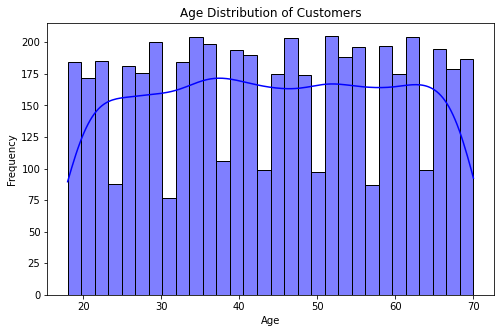

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_final['age'], kde=True, bins=30, color='blue')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [10]:
df_final.dtypes

customer_id                  object
name                         object
age                         float64
gender                       object
marital_status               object
education                    object
occupation                   object
salary                        int64
loan_amount                 float64
credit_limit                float64
credit_utilization          float64
emi_paid                    float64
tenure_months               float64
max_dpd                     float64
default_status              float64
enquiry_amount              float64
unique_products_enquired    float64
total_enquiries             float64
transaction_amount          float64
account_balance             float64
is_salary                   float64
Credit Card                    bool
Home Loan                      bool
Personal Loan                  bool
dtype: object

## Cluster the Data

Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary', 'Credit Card',
       'Home Loan', 'Personal Loan'],
      dtype='object')


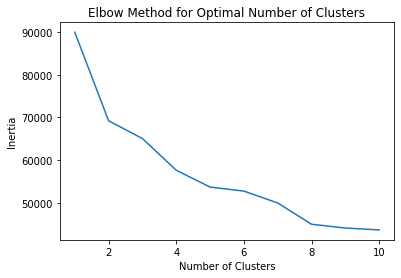

                            customer_id  customer_segment
0  92eef4b2-dbde-41ef-aed9-6329ecf297c9                 1
1  a57ad013-7723-45d0-b150-c7273365d0a8                 1
2  495452b6-7838-4635-8f07-a5f420d0b04f                 0
3  4d67d4b2-9b72-4306-a9e6-e004be6e4cbc                 0
4  3c2a74db-3311-4420-aafd-107db5074a49                 0


In [11]:
clustering_data = df_final.drop(columns=['customer_id', 'name', 'occupation','gender','marital_status','education'])
print(clustering_data.columns)
# Handle missing values
clustering_data.fillna(0, inplace=True)
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)


# Determine optimal number of clusters (elbow method)
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal K (say K=4 based on the elbow curve)
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['customer_segment'] = kmeans.fit_predict(scaled_data)

# View segmented data
print(df_final[['customer_id', 'customer_segment']].head())


In [12]:
pd.set_option('display.max_columns', None)
# Assuming df_final is your DataFrame and 'customer_segment' is the column to group by
float_columns = df_final.select_dtypes(include=['int','float'])
grouped_df = float_columns.groupby('customer_segment')

# Summary of each segment
segment_description = grouped_df.describe()
segment_description


age                                                      \
                   count       mean        std   min   25%   50%   75%   max   
customer_segment                                                               
0                 1728.0  44.815394  15.142292  18.0  32.0  45.5  58.0  70.0   
1                 2253.0  44.041278  15.155751  18.0  31.0  44.0  57.0  70.0   
2                 1019.0  43.556428  15.286058  18.0  30.0  43.0  57.0  70.0   

                  salary                                                     \
                   count          mean           std        min         25%   
customer_segment                                                              
0                 1728.0  5.294276e+06  2.142353e+06  1501272.0  3477795.75   
1                 2253.0  3.177062e+06  1.492803e+06   500530.0  1928724.00   
2                 1019.0  5.109500e+06  2.180977e+06  1275808.0  3246352.50   

                                                  loan_amount                \
                        50%        75%        max       count          mean   
customer_segment                                                              
0                 5282503.5  7165156.5  8999067.0      1728.0  1.055905e+07   
1                 2914052.0  4453778.0  5996210.0      2253.0  6.354432e+06   
2                 4986696.0  6952980.0  8998629.0      1019.0  1.033354e+07   

                                                                       \
                           std         min          25%           50%   
customer_segment                                                        
0                 3.535781e+06  1616943.00  8035912.450  1.049123e+07   
1                 3.922520e+06        0.00  3409724.000  6.026216e+06   
2                 3.581131e+06   393759.25  7815015.975  1.016935e+07   

                                           credit_limit                 \
                           75%         max        count           mean   
customer_segment                                                         
0                 1.309665e+07  22637595.0       1728.0  298557.622571   
1                 9.009844e+06  18525916.4       2253.0  110706.668812   
2                 1.280952e+07  22097493.6       1019.0  293595.068926   

                                                                            \
                            std       min       25%        50%         75%   
customer_segment                                                             
0                  69724.461171  150573.0  248904.0  299486.25  347019.375   
1                 101073.930553       0.0       0.0  127359.00  200454.000   
2                  70183.250321       0.0  246690.5  292026.00  342200.250   

                           credit_utilization                                \
                       max              count      mean       std       min   
customer_segment                                                              
0                 449997.0             1728.0  1.673187  0.632457  0.308061   
1                 299992.0             2253.0  0.611362  0.607986  0.000000   
2                 449106.0             1019.0  1.651992  0.613783  0.000000   

                                                         emi_paid              \
                       25%       50%       75%       max    count        mean   
customer_segment                                                                
0                 1.239701  1.658768  2.130789  2.999876   1728.0  228.818287   
1                 0.000000  0.570954  1.108011  1.994037   2253.0   86.432756   
2                 1.215245  1.648672  2.073715  2.999284   1019.0  227.962709   

                                                              tenure_months  \
                        std   min    25%    50%    75%    max         count   
customer_segment                                                              
0                 87.545944  24.0  165

### Segment Descriptions:
1. **Segment 0: Affluent** :
Higher average salary, loan amount, credit limit, and transaction amounts. These customers have higher financial standing with substantial balances and engagement in high-value transactions.

2. **Segment 1: Cautious** :
Lower loan amounts and credit utilization, fewer enquiries, and lower transaction amounts. This segment seems to manage smaller finances and be more risk-averse or conservative in their credit usage.

3. **Segment 2: Moderate** :
Mid-range loan amounts, credit limits, and financial activity. They display a balanced financial profile with moderate usage across different financial metrics.

## Dynamic Pricing Model - Using Random Forest Regressor

--For finding out predicted loan amount for all the product highlighted

In [13]:
# Prepare data for regression
regression_data = df_final.drop(columns=['customer_id', 'name', 'occupation','gender','marital_status','education'])
regression_data.fillna(-888, inplace=True)

# Split the data for each loan type (Personal Loan, Home Loan, Credit Card)
def prepare_data_for_loan_type(data, loan_type):
    X = data[(data[loan_type] == 1)].drop(columns=['loan_amount'])
    y = data[(data[loan_type] == 1)]['loan_amount']
    return X, y


# Random Forest Regressor with Hyperparameter Tuning
def tune_random_forest(X_train, y_train):
    rf = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_



# Prepare data for Personal Loan
X_personal_loan, y_personal_loan = prepare_data_for_loan_type(regression_data, 'Personal Loan')
X_train_personal_loan, X_test_personal_loan, y_train_personal_loan, y_test_personal_loan = train_test_split(X_personal_loan, y_personal_loan, test_size=0.2, random_state=42)

# Train the model for Personal Loan
rf_regressor_personal_loan, best_params_personal_loan = tune_random_forest(X_train_personal_loan, y_train_personal_loan)

# Evaluate the model for Personal Loan
y_pred_personal_loan = rf_regressor_personal_loan.predict(X_test_personal_loan)
mse_personal_loan = mean_squared_error(y_test_personal_loan, y_pred_personal_loan)
mae_personal_loan = mean_absolute_error(y_test_personal_loan, y_pred_personal_loan)
r2_personal_loan = r2_score(y_test_personal_loan, y_pred_personal_loan)

print(f"Personal Loan - Best Params: {best_params_personal_loan}")
print(f"Personal Loan - MSE: {mse_personal_loan}, MAE: {mae_personal_loan}, R2: {r2_personal_loan}")



# Prepare data for Home Loan
X_home_loan, y_home_loan = prepare_data_for_loan_type(regression_data, 'Home Loan')
X_train_home_loan, X_test_home_loan, y_train_home_loan, y_test_home_loan = train_test_split(X_home_loan, y_home_loan, test_size=0.2, random_state=42)

# Train the model for Home Loan
rf_regressor_home_loan, best_params_home_loan = tune_random_forest(X_train_home_loan, y_train_home_loan)

# Evaluate the model for Home Loan
y_pred_home_loan = rf_regressor_home_loan.predict(X_test_home_loan)
mse_home_loan = mean_squared_error(y_test_home_loan, y_pred_home_loan)
mae_home_loan = mean_absolute_error(y_test_home_loan, y_pred_home_loan)
r2_home_loan = r2_score(y_test_home_loan, y_pred_home_loan)

print(f"Home Loan - Best Params: {best_params_home_loan}")
print(f"Home Loan - MSE: {mse_home_loan}, MAE: {mae_home_loan}, R2: {r2_home_loan}")



# Prepare data for Credit Card
X_credit_card, y_credit_card = prepare_data_for_loan_type(regression_data, 'Credit Card')
X_train_credit_card, X_test_credit_card, y_train_credit_card, y_test_credit_card = train_test_split(X_credit_card, y_credit_card, test_size=0.2, random_state=42)

# Train the model for Credit Card
rf_regressor_credit_card, best_params_credit_card = tune_random_forest(X_train_credit_card, y_train_credit_card)

# Evaluate the model for Credit Card
y_pred_credit_card = rf_regressor_credit_card.predict(X_test_credit_card)
mse_credit_card = mean_squared_error(y_test_credit_card, y_pred_credit_card)
mae_credit_card = mean_absolute_error(y_test_credit_card, y_pred_credit_card)
r2_credit_card = r2_score(y_test_credit_card, y_pred_credit_card)

print(f"Credit Card - Best Params: {best_params_credit_card}")
print(f"Credit Card - MSE: {mse_credit_card}, MAE: {mae_credit_card}, R2: {r2_credit_card}")


Personal Loan - Best Params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Personal Loan - MSE: 10501547883229.879, MAE: 2584804.964780034, R2: 0.2995009868154884
Home Loan - Best Params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Home Loan - MSE: 10871213752382.611, MAE: 2646998.3785568974, R2: 0.3041868582770262
Credit Card - Best Params: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Credit Card - MSE: 10267928291545.807, MAE: 2607613.1828054367, R2: 0.3900586975601462


In [14]:
#Prediction Amount
new_customer_data = X_test_credit_card.iloc[0:1]
predicted_loan_amount = rf_regressor_credit_card.predict(new_customer_data)
print(predicted_loan_amount)

[10332736.96867117]


## Product Recommendation Model - Random Forest Classifier with MultiOutput

In [15]:
classification_data = df_final.copy()
classification_data.fillna(-888, inplace=True)
# Step 2: Drop unnecessary columns for the model and target columns
X_classification = classification_data.drop(columns=['customer_id', 'name', 'occupation', 'gender', 
                                                     'marital_status', 'education', 'Credit Card', 'Home Loan', 'Personal Loan'])
y_classification = classification_data[['Credit Card', 'Home Loan', 'Personal Loan']]  # Multi-output target columns

# Step 3: Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Step 4: Initialize Random Forest Classifier with MultiOutputClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_classifier = MultiOutputClassifier(rf_classifier)

# Step 5: Train the model on the training data for all three outputs
multi_target_classifier.fit(X_train_class, y_train_class)

# Step 6: Predict probabilities for the test set
y_prob_test = [estimator.predict_proba(X_test_class)[:, 1] for estimator in multi_target_classifier.estimators_]

# Combine probabilities into a DataFrame for easier handling
probabilities = pd.DataFrame({
    'Credit Card': y_prob_test[0],   # Probability for Credit Card
    'Home Loan': y_prob_test[1],     # Probability for Home Loan
    'Personal Loan': y_prob_test[2]  # Probability for Personal Loan
})

# Step 7: Find the most probable product for each customer
most_probable_product = probabilities.idxmax(axis=1)

# Optional: Evaluate model performance
y_pred = multi_target_classifier.predict(X_test_class)
print("\nClassification Report for Credit Card:")
print(classification_report(y_test_class['Credit Card'], y_pred[:, 0]))

print("\nClassification Report for Home Loan:")
print(classification_report(y_test_class['Home Loan'], y_pred[:, 1]))

print("\nClassification Report for Personal Loan:")
print(classification_report(y_test_class['Personal Loan'], y_pred[:, 2]))


Classification Report for Credit Card:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       188
        True       1.00      1.00      1.00       812

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000


Classification Report for Home Loan:
              precision    recall  f1-score   support

       False       0.69      0.59      0.64       221
        True       0.89      0.93      0.91       779

    accuracy                           0.85      1000
   macro avg       0.79      0.76      0.77      1000
weighted avg       0.84      0.85      0.85      1000


Classification Report for Personal Loan:
              precision    recall  f1-score   support

       False       0.64      0.53      0.57       179
        True       0.90      0.93      0.92       821

    accuracy                           0.86      1000
   macro

In [16]:
X_classification.columns

Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary',
       'customer_segment'],
      dtype='object')

### Save all the Models

In [17]:
import joblib

# Define the file paths for saving
model_paths = {
    'kmeans': 'models/kmeans_model.pkl',
    'scaler': 'models/scaler.pkl',
    'multi_target_classifier': 'models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'models/rf_regressor_credit_card_model.pkl'
}

# Save models to disk
joblib.dump(kmeans, model_paths['kmeans'])
joblib.dump(scaler, model_paths['scaler'])
joblib.dump(multi_target_classifier, model_paths['multi_target_classifier'])
joblib.dump(rf_regressor_personal_loan, model_paths['rf_regressor_personal_loan'])
joblib.dump(rf_regressor_home_loan, model_paths['rf_regressor_home_loan'])
joblib.dump(rf_regressor_credit_card, model_paths['rf_regressor_credit_card'])

print("Models saved successfully!")

Models saved successfully!


# Combined Code

In [19]:
import joblib
import pandas as pd
import numpy as np

model_paths = {
    'kmeans': 'models/kmeans_model.pkl',
    'scaler': 'models/scaler.pkl',
    'multi_target_classifier': 'models/multi_target_classifier_model.pkl',
    'rf_regressor_personal_loan': 'models/rf_regressor_personal_loan_model.pkl',
    'rf_regressor_home_loan': 'models/rf_regressor_home_loan_model.pkl',
    'rf_regressor_credit_card': 'models/rf_regressor_credit_card_model.pkl'
}

kmeans = joblib.load(model_paths['kmeans'])
scaler = joblib.load(model_paths['scaler'])
multi_target_classifier = joblib.load(model_paths['multi_target_classifier'])
rf_regressor_personal_loan = joblib.load(model_paths['rf_regressor_personal_loan'])
rf_regressor_home_loan = joblib.load(model_paths['rf_regressor_home_loan'])
rf_regressor_credit_card = joblib.load(model_paths['rf_regressor_credit_card'])

print("Models loaded successfully!")


def process_customer_data(json_data, scaler):
    # Convert JSON data to a DataFrame
    customer_data = pd.DataFrame([json_data])
    
    # Drop columns not needed for clustering (based on your clustering model)
    clustering_data = customer_data
    
    # Handle missing values by replacing with 0 (or any appropriate strategy)
    clustering_data.fillna(0, inplace=True)
    
    scaled_data = scaler.transform(clustering_data)
    
    return customer_data, scaled_data

def predict_customer_segment(scaled_data, kmeans):
    # Predict the customer segment using your pre-trained KMeans model
    customer_segment = kmeans.predict(scaled_data)
    return customer_segment[0]

def recommend_product_and_loan(json_data, kmeans, scaler, multi_target_classifier, rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card):
    # Convert JSON data to a DataFrame and scale the data
    customer_data, scaled_data = process_customer_data(json_data, scaler)

    # Step 1: Predict customer segment using KMeans
    customer_segment = predict_customer_segment(scaled_data, kmeans)
    
    # Add the predicted customer segment back to the customer_data DataFrame
    customer_data['customer_segment'] = customer_segment
    print(customer_data.columns)
    # Prepare for product recommendation using Random Forest Classifier
    X_classification_prod = customer_data.drop(columns=['Credit Card', 'Home Loan', 'Personal Loan'])
    X_classification_amt = customer_data
    
    # Step 2: Predict probabilities for each product using the multi-output classifier
    prob_credit_card = [estimator.predict_proba(X_classification_prod)[:, 1] for estimator in multi_target_classifier.estimators_]

    # Combine probabilities into a Series
    product_probabilities = pd.Series({
        'Credit Card': prob_credit_card[0][0],  # Since it's for one customer, we get the first value
        'Home Loan': prob_credit_card[1][0],
        'Personal Loan': prob_credit_card[2][0]
    })

    print(product_probabilities)
    
    # Identify the most probable product
    recommended_product = product_probabilities.idxmax()    
    recommended_probability = product_probabilities.max()

    recommendation = f"Recommended Product: {recommended_product} (Probability: {recommended_probability:.2f})"

    # Step 3: Predict loan amounts or credit limits based on the recommended product
    if recommended_product == 'Personal Loan':
        predicted_loan_amount_personal = rf_regressor_personal_loan.predict(X_classification_amt.drop(columns=['loan_amount']))
        recommendation += f"\nPredicted Loan Amount: {predicted_loan_amount_personal[0]:,.2f}"
    
    elif recommended_product == 'Home Loan':
        predicted_loan_amount_home = rf_regressor_home_loan.predict(X_classification_amt.drop(columns=['loan_amount']))  
        recommendation += f"\nPredicted Loan Amount: {predicted_loan_amount_home[0]:,.2f}"
    
    elif recommended_product == 'Credit Card':
        predicted_credit_limit = rf_regressor_credit_card.predict(X_classification_amt.drop(columns=['loan_amount']))
        recommendation += f"\nPredicted Credit Limit: {predicted_credit_limit[0]:,.2f}"
    
    if recommended_probability < 0.5:
        recommendation = "No suitable product recommendations found for this customer."
    
    return recommendation, customer_segment, product_probabilities

# Example customer JSON data
example_json = {
    'age': 35, 'salary': 50000, 'loan_amount': 0, 'credit_limit': 10000, 
    'credit_utilization': 0.3, 'emi_paid': 1000, 'tenure_months': 12, 
    'max_dpd': 30, 'default_status': 0, 'enquiry_amount': 1000, 
    'unique_products_enquired': 3, 'total_enquiries': 5, 
    'transaction_amount': 5000, 'account_balance': 15000, 'is_salary': 1,
    'Credit Card': 1, 'Home Loan': 0, 'Personal Loan': 0, 
}

# print(X)
# Example usage:
recommend_product_and_loan(example_json, kmeans, scaler, multi_target_classifier, rf_regressor_personal_loan, rf_regressor_home_loan, rf_regressor_credit_card)

Models loaded successfully!
Index(['age', 'salary', 'loan_amount', 'credit_limit', 'credit_utilization',
       'emi_paid', 'tenure_months', 'max_dpd', 'default_status',
       'enquiry_amount', 'unique_products_enquired', 'total_enquiries',
       'transaction_amount', 'account_balance', 'is_salary', 'Credit Card',
       'Home Loan', 'Personal Loan', 'customer_segment'],
      dtype='object')
Credit Card      0.44
Home Loan        0.43
Personal Loan    0.40
dtype: float64


('No suitable product recommendations found for this customer.',
 1,
 Credit Card      0.44
 Home Loan        0.43
 Personal Loan    0.40
 dtype: float64)

## Loading the LLM to generate Insights

In [20]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain.llms import HuggingFacePipeline
from functools import lru_cache

@lru_cache(maxsize=None)
def load_model():
    model_name = "KingNish/Qwen2.5-0.5b-Test-ft"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    return tokenizer, model

# Function to generate insights based on customer data
def generate_insights(customer_data):
    tokenizer, model = load_model()

    # Format currency according to Indian standards
    def format_inr(amount):
        return f"₹{amount:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

    # Create a prompt from the customer data
    prompt = f"""
    Generate a personalized summarised insight about the following customer based on their data whether it can be a good customer to onboard as a banking entity:
    
    - Name: {customer_data['name']}
    - Age: {customer_data['age']}
    - Gender: {customer_data['gender']}
    - Marital Status: {customer_data['marital_status']}
    - Education: {customer_data['education']}
    - Occupation: {customer_data['occupation']}
    - Salary: {format_inr(customer_data['salary'])}
    - Loan Amount: {format_inr(customer_data['loan_amount'])}
    - Product Type: {customer_data['product_type']}
    - Credit Limit: {format_inr(customer_data['credit_limit']) if customer_data['credit_limit'] else 'N/A'}
    - Credit Utilization: {customer_data['credit_utilization']:.2%}
    - EMI Paid: {customer_data['emi_paid']}
    - Tenure Months: {round(float(customer_data['tenure_months']), 2)}
    - Max DPD: {customer_data['max_dpd']}
    - Default Status: {int(customer_data['default_status'])}
    - Account Balance: {format_inr(customer_data['account_balance'])}

    Here are the Summarized Insights about {customer_data['name']}:
    """

    # Initialize the query pipeline with increased max_length
    query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        max_length=6000,  # Increase max_length
        max_new_tokens=500,  # Control the number of new tokens generated
        device_map="auto",
    )

    # Instantiate HuggingFacePipeline correctly
    llm = HuggingFacePipeline(pipeline=query_pipeline)

    # Generate insights
    insights = llm(prompt)
    return insights


In [21]:
import pandas as pd
import json

def df_row_to_json(row):
    data = row.to_dict()
    for key, value in data.items():
        if pd.isnull(value):
            data[key] = None
        elif isinstance(value, pd.Timestamp):
            data[key] = value.isoformat()

    # Convert to JSON string
    json_str = json.dumps(data, indent=4)
    return json_str

# Assuming `merged_data` is a DataFrame and we're converting row 8 to JSON
json_data_str = df_row_to_json(df_final.iloc[6])

# Now convert the JSON string back to a dictionary to access fields
json_data_dict = json.loads(json_data_str)

# insights = generate_insights(json_data_dict)
print(json_data_str)
pd.DataFrame.from_dict(json_data_dict, orient='index').T

{
    "customer_id": "932aaafc-ebea-494e-b7ba-a243eb242d9f",
    "name": "Joshua Adams",
    "age": 48.0,
    "gender": "Male",
    "marital_status": "Divorced",
    "education": "Bachelor",
    "occupation": "Geologist, engineering",
    "salary": 4229516,
    "loan_amount": 7115278.0,
    "credit_limit": 104548.0,
    "credit_utilization": 0.9112386425827257,
    "emi_paid": 66.0,
    "tenure_months": 86.66666666666667,
    "max_dpd": 120.0,
    "default_status": 0.3333333333333333,
    "enquiry_amount": 884861.0,
    "unique_products_enquired": 4.0,
    "total_enquiries": 4.0,
    "transaction_amount": 0.0,
    "account_balance": 19810.22145702188,
    "is_salary": 0.0,
    "Credit Card": true,
    "Home Loan": true,
    "Personal Loan": false,
    "customer_segment": 1
}


,customer_id,name,age,gender,marital_status,education,occupation,salary,loan_amount,credit_limit,credit_utilization,emi_paid,tenure_months,max_dpd,default_status,enquiry_amount,unique_products_enquired,total_enquiries,transaction_amount,account_balance,is_salary,Credit Card,Home Loan,Personal Loan,customer_segment
0,932aaafc-ebea-494e-b7ba-a243eb242d9f,Joshua Adams,48.0,Male,Divorced,Bachelor,"Geologist, engineering",4229516,7115278.0,104548.0,0.911239,66.0,86.666667,120.0,0.333333,884861.0,4.0,4.0,0.0,19810.221457,0.0,True,True,False,1


In [23]:
import re

# Function to clean unwanted characters and extract the insight
def clean_and_extract_insight(insights):
    # Remove unwanted characters (non-alphanumeric characters except spaces)
    cleaned_insight = re.sub(r'[^a-zA-Z0-9\s]', '', insights)
    
    # Extract the portion after "Summarised Insight"
    if "Here are the Summarised Insights about" in cleaned_insight:
        extracted_insight = cleaned_insight.split("Here are the Summarised Insights about")[1].strip().split("\n\n")[0]
    else:
        extracted_insight = cleaned_insight.strip()

    return extracted_insight

# Example usage
cleaned_insight = clean_and_extract_insight(insights)
print(cleaned_insight.strip())

NameError: name 'insights' is not defined

In [ ]:
data = cleaned_insight.split("\n")[1:]
all_data = list()
for line in data:
    all_data.append(line.strip())

all_data